/opt/homebrew/lib/python3.11/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/2ffce0501d0aecad81b43a06d538186e292d0070/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.1. Bad things might happen unless you revert torch to 1.x.


Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/c6335d8f1cd77b30084387468a6cf26fea90009b/pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/c6335d8f1cd77b30084387468a6cf26fea90009b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.2.1. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.2.1. Bad things might happen unless you revert torch to 1.x.


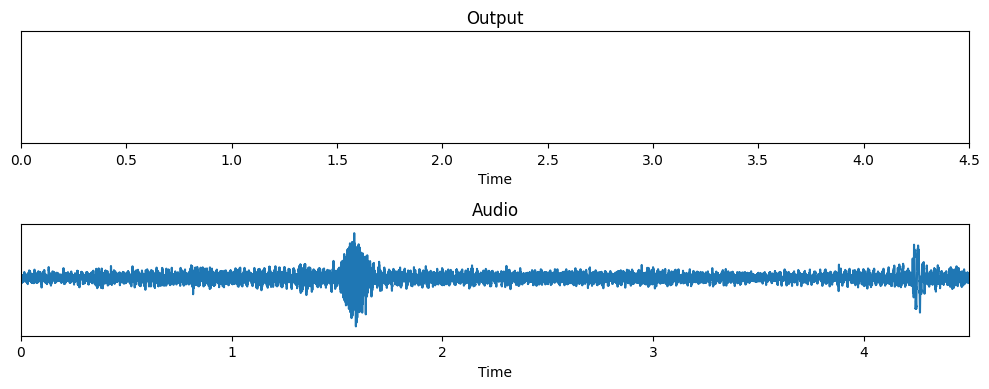

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [1]:
from diart import SpeakerDiarization
from diart.sources import MicrophoneAudioSource
from diart.inference import StreamingInference
from diart.sinks import RTTMWriter

pipeline = SpeakerDiarization()
mic = MicrophoneAudioSource()
inference = StreamingInference(pipeline, mic, do_plot=True)
prediction = inference()

In [3]:
import logging
import os
import sys
import traceback
from contextlib import contextmanager

import diart.operators as dops
import numpy as np
import rich
import rx.operators as ops
import whisper_timestamped as whisper
from diart import SpeakerDiarization, SpeakerDiarizationConfig
from diart.sources import MicrophoneAudioSource
from pyannote.core import Annotation, SlidingWindowFeature, SlidingWindow, Segment


def concat(chunks, collar=0.05):
    """
    Concatenate predictions and audio
    given a list of `(diarization, waveform)` pairs
    and merge contiguous single-speaker regions
    with pauses shorter than `collar` seconds.
    """
    first_annotation = chunks[0][0]
    first_waveform = chunks[0][1]
    annotation = Annotation(uri=first_annotation.uri)
    data = []
    for ann, wav in chunks:
        annotation.update(ann)
        data.append(wav.data)
    annotation = annotation.support(collar)
    window = SlidingWindow(
        first_waveform.sliding_window.duration,
        first_waveform.sliding_window.step,
        first_waveform.sliding_window.start,
    )
    data = np.concatenate(data, axis=0)
    return annotation, SlidingWindowFeature(data, window)


def colorize_transcription(transcription):
    """
    Unify a speaker-aware transcription represented as
    a list of `(speaker: int, text: str)` pairs
    into a single text colored by speakers.
    """
    colors = 2 * [
        "bright_red", "bright_blue", "bright_green", "orange3", "deep_pink1",
        "yellow2", "magenta", "cyan", "bright_magenta", "dodger_blue2"
    ]
    result = []
    for speaker, text in transcription:
        if speaker == -1:
            # No speakerfound for this text, use default terminal color
            result.append(text)
        else:
            result.append(f"[{colors[speaker]}]{text}")
    return "\n".join(result)

@contextmanager
def suppress_stdout():
    # Auxiliary function to suppress Whisper logs (it is quite verbose)
    # All credit goes to: https://thesmithfam.org/blog/2012/10/25/temporarily-suppress-console-output-in-python/
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


class WhisperTranscriber:
    def __init__(self, model="small", device=None):
        self.model = whisper.load_model(model, device=device)
        self._buffer = ""

    def transcribe(self, waveform):
        """Transcribe audio using Whisper"""
        # Pad/trim audio to fit 30 seconds as required by Whisper
        audio = waveform.data.astype("float32").reshape(-1)
        audio = whisper.pad_or_trim(audio)

        # Transcribe the given audio while suppressing logs
        with suppress_stdout():
            transcription = whisper.transcribe(
                self.model,
                audio,
                # We use past transcriptions to condition the model
                initial_prompt=self._buffer,
                verbose=True  # to avoid progress bar
            )

        return transcription

    def identify_speakers(self, transcription, diarization, time_shift):
        """Iterate over transcription segments to assign speakers"""
        speaker_captions = []
        for segment in transcription["segments"]:

            # Crop diarization to the segment timestamps
            start = time_shift + segment["words"][0]["start"]
            end = time_shift + segment["words"][-1]["end"]
            dia = diarization.crop(Segment(start, end))

            # Assign a speaker to the segment based on diarization
            speakers = dia.labels()
            num_speakers = len(speakers)
            if num_speakers == 0:
                # No speakers were detected
                caption = (-1, segment["text"])
            elif num_speakers == 1:
                # Only one speaker is active in this segment
                spk_id = int(speakers[0].split("speaker")[1])
                caption = (spk_id, segment["text"])
            else:
                # Multiple speakers, select the one that speaks the most
                max_speaker = int(np.argmax([
                    dia.label_duration(spk) for spk in speakers
                ]))
                caption = (max_speaker, segment["text"])
            speaker_captions.append(caption)

        return speaker_captions

    def __call__(self, diarization, waveform):
        # Step 1: Transcribe
        transcription = self.transcribe(waveform)
        # Update transcription buffer
        self._buffer += transcription["text"]
        # The audio may not be the beginning of the conversation
        time_shift = waveform.sliding_window.start
        # Step 2: Assign speakers
        speaker_transcriptions = self.identify_speakers(transcription, diarization, time_shift)
        return speaker_transcriptions


# Suppress whisper-timestamped warnings for a clean output
logging.getLogger("whisper_timestamped").setLevel(logging.ERROR)

# If you have a GPU, you can also set device=torch.device("cuda")
config = SpeakerDiarizationConfig(
    duration=5,
    step=0.5,
    latency="min",
    tau_active=0.5,
    rho_update=0.1,
    delta_new=0.57
)
dia = SpeakerDiarization(config)
source = MicrophoneAudioSource(config.sample_rate)

# If you have a GPU, you can also set device="cuda"
asr = WhisperTranscriber(model="small")

# Split the stream into 2s chunks for transcription
transcription_duration = 2
# Apply models in batches for better efficiency
batch_size = int(transcription_duration // config.step)

# Chain of operations to apply on the stream of microphone audio
source.stream.pipe(
    # Format audio stream to sliding windows of 5s with a step of 500ms
    dops.rearrange_audio_stream(
        config.duration, config.step, config.sample_rate
    ),
    # Wait until a batch is full
    # The output is a list of audio chunks
    ops.buffer_with_count(count=batch_size),
    # Obtain diarization prediction
    # The output is a list of pairs `(diarization, audio chunk)`
    ops.map(dia),
    # Concatenate 500ms predictions/chunks to form a single 2s chunk
    ops.map(concat),
    # Ignore this chunk if it does not contain speech
    ops.filter(lambda ann_wav: ann_wav[0].get_timeline().duration() > 0),
    # Obtain speaker-aware transcriptions
    # The output is a list of pairs `(speaker: int, caption: str)`
    ops.starmap(asr),
    # Color transcriptions according to the speaker
    # The output is plain text with color references for rich
    ops.map(colorize_transcription),
).subscribe(
    on_next=rich.print,  # print colored text
    on_error=lambda _: traceback.print_exc()  # print stacktrace if error
)

print("Listening...")
source.read()

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/2ffce0501d0aecad81b43a06d538186e292d0070/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.1. Bad things might happen unless you revert torch to 1.x.


Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/c6335d8f1cd77b30084387468a6cf26fea90009b/pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/c6335d8f1cd77b30084387468a6cf26fea90009b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.2.1. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.2.1. Bad things might happen unless you revert torch to 1.x.
Listening...


Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/diart/sources.py", line 190, in read
    if self._mic_stream.closed:
       ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sounddevice.py", line 1041, in closed
    @property
    
KeyboardInterrupt
